In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo 
import xgboost as xgb
from sklearn.impute import SimpleImputer
  
# fetch dataset 
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938) 
  
# data (as pandas dataframes) 
X = regensburg_pediatric_appendicitis.data.features 
y = regensburg_pediatric_appendicitis.data.targets

# Merging X and y to data
data = pd.merge(X, y, left_index=True, right_index=True)
data.shape

(782, 56)

In [2]:
# deleting not needed target variables from data
data = data.drop(['Management', 'Severity'], axis=1)
data.shape

(782, 54)

In [3]:
# removing all NAN values from diagnosis
data = data.dropna(subset=['Diagnosis'])
data.shape

(780, 54)

In [4]:
# Checking for NAN values
data[data['Diagnosis'].isna()]

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Pathological_Lymph_Nodes,Lymph_Nodes_Location,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings,Diagnosis


In [5]:
data.columns

Index(['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay',
       'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US',
       'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea',
       'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count',
       'Neutrophil_Percentage', 'Segmented_Neutrophils', 'Neutrophilia',
       'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count',
       'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria',
       'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness',
       'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign',
       'Appendicolith', 'Perfusion', 'Perforation',
       'Surrounding_Tissue_Reaction', 'Appendicular_Abscess',
       'Abscess_Location', 'Pathological_Lymph_Nodes', 'Lymph_Nodes_Location',
       'Bowel_Wall_Thickening', 'Conglomerate_of_Bowel_Loops', 'Ileus',
       'Coprostasis', 'Me

In [6]:
def convert_variables(df):
    # Demographic Variables
    df["Sex"] = df["Sex"].replace(['male', 'female', 'no'], [1, 0, np.nan])
    
    # Clinical Variables
    df["Peritonitis"] = df["Peritonitis"].replace({"no": 0, "local": 1, "generalized": 1})
    df["Migratory_Pain"] = df["Migratory_Pain"].replace({'yes': 1, 'no': 0})
    df["Lower_Right_Abd_Pain"].replace({'yes': 1, 'no': 0})
    df["Contralateral_Rebound_Tenderness"] = df["Contralateral_Rebound_Tenderness"].replace({'yes': 1, 'no': 0})
    df["Coughing_Pain"] = df["Coughing_Pain"].replace({'yes': 1, 'no': 0})
    df["Psoas_Sign"] = df["Psoas_Sign"].replace({'yes': 1, 'no': 0})
    df["Nausea"] = df["Nausea"].replace({'yes': 1, 'no': 0})
    df["Loss_of_Appetite"] = df["Loss_of_Appetite"].replace({'yes': 1, 'no': 0})
    df["Dysuria"] = df["Dysuria"].replace({'yes': 1, 'no': 0})
    df["Ipsilateral_Rebound_Tenderness"] = df["Ipsilateral_Rebound_Tenderness"].replace({'yes': 1, 'no': 0})
    df["Stool"] = df["Stool"].replace({'diarrhea': 1, 'normal': 0, 'constipation': 1, 'constipation, diarrhea': 1, 'no': 0})
    df["Lower_Right_Abd_Pain"] = df["Lower_Right_Abd_Pain"].replace({'yes': 1, 'no': 0})
    
    # Laboratory Variables
    df["Ketones_in_Urine"] = df["Ketones_in_Urine"].replace({'no': 0, '+': 1, '++': 1, '+++': 1})
    df["RBC_in_Urine"] = df["RBC_in_Urine"].replace({'no': 0, '+': 1, '++': 1, '+++': 1})
    df["WBC_in_Urine"] = df["WBC_in_Urine"].replace({'no': 0, '+': 1, '++': 1, '+++': 1})
    df["Neutrophilia"] = df["Neutrophilia"].replace({'yes': 1, 'no': 0})
    
    # Ultrasound Variables
    df["US_Performed"] = df["US_Performed"].replace({'yes': 1, 'no': 0})
    df["Appendix_on_US"] = df["Appendix_on_US"].replace({'yes': 1, 'no': 0})
    df["Free_Fluids"] = df["Free_Fluids"].replace({'yes': 1, 'no': 0})
    df["Appendix_Wall_Layers"] = df["Appendix_Wall_Layers"].replace({"intact": 0, "no": 0, "raised": 1, "partially raised": 1, "upset": 1})
    df['Target_Sign'] = df['Target_Sign'].replace({'yes': 1, 'no': 0})
    df["Perfusion"] = df["Perfusion"].replace({"no": 0, "present": 1, "hypoperfused": 0, "hyperperfused": 1})
    df["Perforation"] = df["Perforation"].replace({"no": 0, "suspected": 1, "not excluded": np.nan, "yes": 1})
    df["Surrounding_Tissue_Reaction"] = df["Surrounding_Tissue_Reaction"].replace({'yes': 1, 'no': 0})
    df["Pathological_Lymph_Nodes"] = df["Pathological_Lymph_Nodes"].replace({'yes': 1, 'no': 0})
    df["Bowel_Wall_Thickening"] = df["Bowel_Wall_Thickening"].replace({'yes': 1, 'no': 0})
    df["Ileus"] = df["Ileus"].replace({'yes': 1, 'no': 0})
    df["Coprostasis"] = df["Coprostasis"].replace({'yes': 1, 'no': 0})
    df["Meteorism"] = df["Meteorism"].replace({'yes': 1, 'no': 0})
    df["Enteritis"] = df["Enteritis"].replace({'yes': 1, 'no': 0})
    df["Appendicular_Abscess"] = df["Appendicular_Abscess"].replace({"no": 0, "suspected": 1, "yes": 1})
    df["Conglomerate_of_Bowel_Loops"] = df["Conglomerate_of_Bowel_Loops"].replace({'yes': 1, 'no': 0})
    df["Appendicolith"] = df["Appendicolith"].replace({"no": 0, "suspected": 1, "yes": 1})
    df["Gynecological_Findings"] = df["Gynecological_Findings"].replace({'Ovarialzyste': 1, 
                                                                        'Zyste Uterus': 1,
                                                                        'In beiden Ovarien Zysten darstellbar, links Ovar mit regelrechter Perfusion, rechts etwas vergrößert, keine eindeutige Perfusion nachweisbar. Retrovesikal freie Flüssigkeit mit Binnenecho': 1,
                                                                        'Ausschluss pathologischer Ovarialbefund': 1,
                                                                        'kleine Ovarzyste rechts': 1,
                                                                        'kein Anhalt für eine gynäkologische Ursache der Beschwerden': 0,
                                                                        'V. a. Ovarialtorsion': 1,
                                                                        'Ausschluss gyn. Ursache der Beschwerden': 0,
                                                                        'ja': 1,
                                                                        'keine': 0,
                                                                        'Ovarialzysten': 1,
                                                                        'Ovarialzyste re.': 1,
                                                                        'unauffällig': 0,
                                                                        'Ovarialzyste ': 1})    
    
    # Diagnosis
    df["Diagnosis"] = df["Diagnosis"].replace({'appendicitis': 1, 'no appendicitis': 0})
    
    # Dropping Columns
    df.drop("Lymph_Nodes_Location", axis=1, inplace=True)
    df.drop("Abscess_Location", axis=1, inplace=True)
    
    return df

In [7]:
def impute_US(df):
    df['Appendix_Wall_Layers'] = df['Appendix_Wall_Layers'].replace({np.nan: 0})
    df['Target_Sign'] = df['Target_Sign'].replace({np.nan: 0})
    df['Perforation'] = df['Perforation'].replace({np.nan: 0})
    df['Appendicular_Abscess'] = df['Appendicular_Abscess'].replace({np.nan: 0})
    df['Conglomerate_of_Bowel_Loops'] = df['Conglomerate_of_Bowel_Loops'].replace({np.nan: 0})
    df['Enteritis'] = df['Enteritis'].replace({np.nan: 0})
    df['Appendix_on_US'] = df['Appendix_on_US'].replace({np.nan: 0})
    df['Pathological_Lymph_Nodes'] = df['Pathological_Lymph_Nodes'].replace({np.nan: 0})
    df['Ileus'] = df['Ileus'].replace({np.nan: 0})
    df['Coprostasis'] = df['Coprostasis'].replace({np.nan: 0})
    df['Meteorism'] = df['Meteorism'].replace({np.nan: 0})
    df['Gynecological_Findings'] = df['Gynecological_Findings'].replace({np.nan: 0})
    df['Surrounding_Tissue_Reaction'] = df['Surrounding_Tissue_Reaction'].replace({np.nan: 0})
    df['Free_Fluids'] = df['Free_Fluids'].replace({np.nan: 0})
    df['Bowel_Wall_Thickening'] = df['Bowel_Wall_Thickening'].replace({np.nan: 0})
    
    return df

In [8]:
data = convert_variables(data)
data = impute_US(data)
data.head()

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Appendicular_Abscess,Pathological_Lymph_Nodes,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings,Diagnosis
0,12.68,16.9,0.0,148.0,37.0,3.0,4.0,3.0,1.0,7.1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,14.10,31.9,1.0,147.0,69.5,2.0,5.0,4.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,14.14,23.3,0.0,163.0,62.0,4.0,5.0,3.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0
3,16.37,20.6,0.0,165.0,56.0,3.0,7.0,6.0,0.0,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,11.08,16.9,0.0,163.0,45.0,3.0,5.0,6.0,1.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


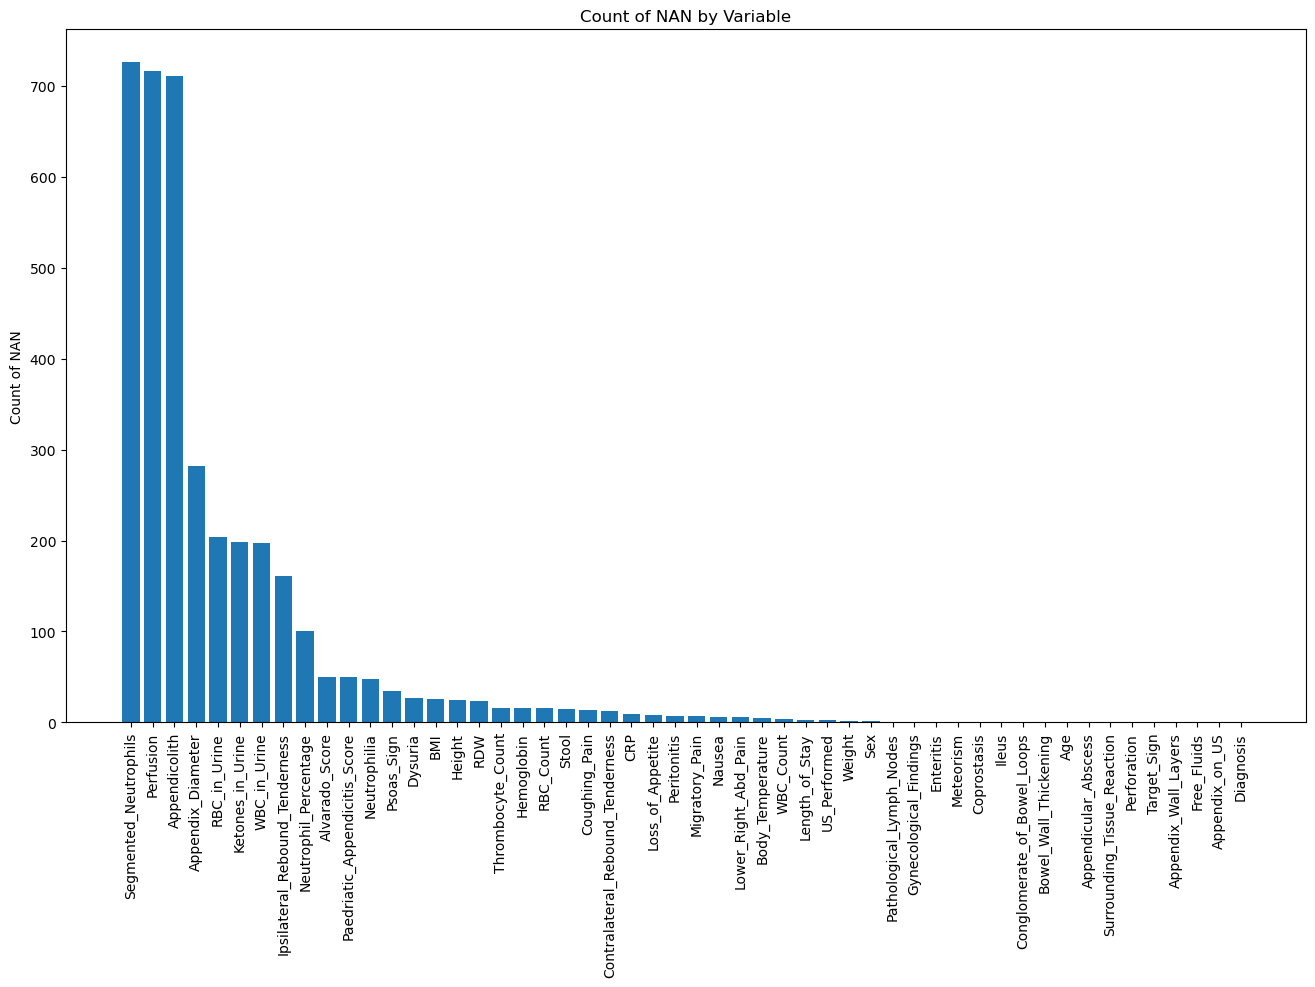

In [9]:
# visualizing count of NAN values
nan_counts = data.isna().sum()
nan_counts_sorted = nan_counts.sort_values(ascending=False)  # Sort values in descending order

plt.figure(figsize=(16, 9))
plt.bar(nan_counts_sorted.index, nan_counts_sorted.values)
plt.xticks(rotation=90)
plt.title('Count of NAN by Variable')
plt.ylabel('Count of NAN')
plt.show()

In [10]:
from sklearn.impute import KNNImputer


In [11]:
imputation_knn = KNNImputer(n_neighbors=2)
new_data = imputation_knn.fit_transform(data)

In [12]:
new_data = pd.DataFrame(new_data, columns=data.columns)

In [13]:
new_data

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Appendicular_Abscess,Pathological_Lymph_Nodes,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings,Diagnosis
0,12.68,16.90,0.0,148.0,37.0,3.0,4.0,3.0,1.0,7.10,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,14.10,31.90,1.0,147.0,69.5,2.0,5.0,4.0,0.0,4.50,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,14.14,23.30,0.0,163.0,62.0,4.0,5.0,3.0,0.0,6.55,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,16.37,20.60,0.0,165.0,56.0,3.0,7.0,6.0,0.0,7.10,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,11.08,16.90,0.0,163.0,45.0,3.0,5.0,6.0,1.0,7.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,12.41,25.25,0.0,166.5,70.0,4.0,8.0,7.0,1.0,7.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
776,17.09,20.43,0.0,158.0,51.0,6.0,5.0,3.0,0.0,10.50,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
777,14.99,19.91,0.0,152.0,46.0,4.0,5.0,3.0,0.0,7.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
778,7.20,14.30,1.0,129.3,23.9,5.0,9.0,8.0,1.0,14.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 52 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               780 non-null    float64
 1   BMI                               780 non-null    float64
 2   Sex                               780 non-null    float64
 3   Height                            780 non-null    float64
 4   Weight                            780 non-null    float64
 5   Length_of_Stay                    780 non-null    float64
 6   Alvarado_Score                    780 non-null    float64
 7   Paedriatic_Appendicitis_Score     780 non-null    float64
 8   Appendix_on_US                    780 non-null    float64
 9   Appendix_Diameter                 780 non-null    float64
 10  Migratory_Pain                    780 non-null    float64
 11  Lower_Right_Abd_Pain              780 non-null    float64
 12  Contrala

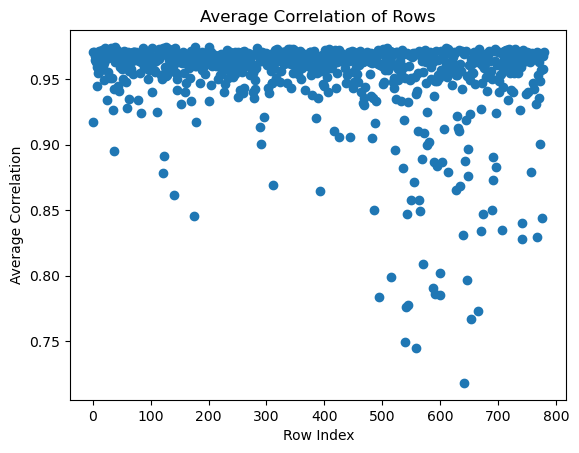

In [32]:
data_transposed = new_data.transpose()

correlation_rows = data_transposed.corr()

mean_correlation_rows = correlation_rows.mean(axis=1)

plt.scatter(range(len(means)), means)
plt.xlabel('Row Index')
plt.ylabel('Average Correlation')
plt.title('Average Correlation of Rows')
plt.show()

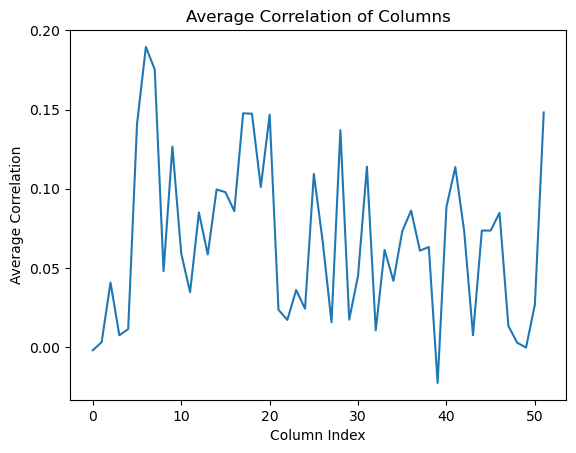

In [33]:
correlation_columns = new_data.corr()

mean_correlation_columns = correlation_columns.mean(axis=1)

plt.plot(range(len(mean_correlation_columns)), mean_correlation_columns)
plt.xlabel('Column Index')
plt.ylabel('Average Correlation')
plt.title('Average Correlation of Columns')
plt.show()